[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data-augmentation/VAE-CNN.ipynb)


In [ ]:
import yaml
import argparse
import torch
import cv2
import random
import os
import shutil
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
# from einops import rearrange
# import pickle
from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True, num_workers=0) # loading the downloaded dataset

100%|██████████| 9912422/9912422 [00:00<00:00, 75766879.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77700894.05it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24795073.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2821882.50it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Modelling

In [ ]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()

        # Encoder - CNN
        layer_1 = nn.Sequential(nn.Conv2d(1, 16,kernel_size=2, stride=2), nn.BatchNorm2d(16), nn.LeakyReLU())
        layer_2 = nn.Sequential(nn.Conv2d(16, 32,kernel_size=2, stride=2), nn.BatchNorm2d(32), nn.LeakyReLU())
        layer_3 = nn.Sequential(nn.Conv2d(32, 64,kernel_size=2, stride=2), nn.BatchNorm2d(64), nn.LeakyReLU())
        self.encoder_layers = nn.ModuleList([layer_1, layer_2, layer_3])

        # mean & variance encoder - FFNN
        layer_1 = nn.Sequential(nn.Linear(576, 128), nn.Identity())
        layer_2 = nn.Sequential(nn.Linear(128, 2), nn.Identity())
        self.encoder_mu_fc = nn.ModuleList([layer_1, layer_2])
        self.encoder_var_fc = nn.ModuleList([layer_1, layer_2])

        # decoder - FFNN
        layer_1 = nn.Sequential(nn.Linear(2, 128), nn.LeakyReLU())
        layer_2 = nn.Sequential(nn.Linear(128, 576), nn.LeakyReLU())
        self.decoder_fc = nn.ModuleList([layer_1, layer_2])

        # decoder - CNN
        layer_1 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=3,stride=2), nn.BatchNorm2d(32), nn.Tanh())
        layer_2 = nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), nn.BatchNorm2d(16), nn.Tanh())
        layer_3 = nn.Sequential(nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2), nn.BatchNorm2d(1),nn.Tanh())
        self.decoder_layers = nn.ModuleList([layer_1, layer_2, layer_3])

    def forward(self, x):
        out = x

        # encoder
        for layer in self.encoder_layers:
            out = layer(out)
        out = out.reshape((x.size(0), -1))

        mu = out
        std = out

        for layer in self.encoder_mu_fc:
            mu = layer(mu)

        for layer in self.encoder_var_fc:
            std = layer(std)

        # sampling
        std = torch.exp(0.5 * std)
        z = torch.randn_like(std) * std + mu

        # decoder fc
        out = z
        for layer in self.decoder_fc:
            out = layer(out)

        # decoder : Figure out how to reshape based on desired number of channels in transpose convolution
        hw = torch.as_tensor(out.size(-1) / 64).to(device) # dividing by 64 cause first layer of hidden CNN is 64 units
        spatial = int(torch.sqrt(hw))

        out = out.reshape((z.size(0), -1, spatial, spatial))
        for layer in self.decoder_layers:
            out = layer(out)

        return mu, std, out

## Training

In [ ]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=0.005)

In [ ]:
for epoch_idx in range(10):

    recon_losses = []
    kl_losses = []
    losses = []

    for im, _ in tqdm(mnist_loader):

        im = im.float().to(device)
        optimizer.zero_grad()
        mean, log_variance, generated_im = model(im)

        # losses
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(log_variance) + mean ** 2 - 1 - log_variance, dim=-1))
        recon_loss = torch.nn.MSELoss()(generated_im, im)
        loss = recon_loss + 0.00001 * kl_loss

        # house keeping
        recon_losses.append(recon_loss.item())
        losses.append(loss.item())
        kl_losses.append(kl_loss.item())

        loss.backward()
        optimizer.step()

    print('Finished epoch: {} | Recon Loss : {:.4f} | KL Loss : {:.4f}'.format(epoch_idx + 1, np.mean(recon_losses), np.mean(kl_losses)))

100%|██████████| 938/938 [01:04<00:00, 14.60it/s]


Finished epoch: 1 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [00:56<00:00, 16.65it/s]


Finished epoch: 2 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [00:57<00:00, 16.27it/s]


Finished epoch: 3 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [00:58<00:00, 15.97it/s]


Finished epoch: 4 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [01:04<00:00, 14.54it/s]


Finished epoch: 5 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [00:58<00:00, 15.91it/s]


Finished epoch: 6 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [00:57<00:00, 16.42it/s]


Finished epoch: 7 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [00:57<00:00, 16.22it/s]


Finished epoch: 8 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [00:56<00:00, 16.58it/s]


Finished epoch: 9 | Recon Loss : nan | KL Loss : nan


100%|██████████| 938/938 [00:56<00:00, 16.58it/s]

Finished epoch: 10 | Recon Loss : nan | KL Loss : nan


## Inference

In [ ]:
# Getting 100 random indexes
idxs = torch.randint(0, len(mnist)-1, (100, ))

# using these indexes to get images from mnist dataset and concatenating them
test_ims = torch.cat([mnist[idx][0][None, :] for idx in idxs]).float()

# generating images for the above test dataset
_, _, generated_im = model(test_ims)

In [ ]:
generated_im = torch.clamp(generated_im, -1., 1.).detach().cpu() # clamping the generated images
generated_im = 0.5*generated_im + 0.5 #detransforming the images from [-1,1] to [0,1]

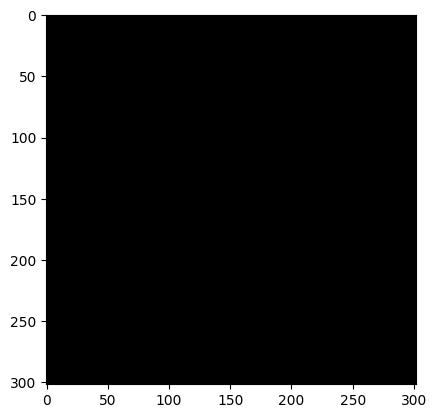

In [ ]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_im, nrow=10)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray')